In [1]:
import torch


In [2]:
from google.colab import files
files.upload()   # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raspingharecodes","key":"8adafb8a86743689a528dc5fc5ce79c2"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
 93% 354M/380M [00:00<00:00, 1.85GB/s]
100% 380M/380M [00:00<00:00, 1.85GB/s]


In [5]:
!unzip augmented-alzheimer-mri-dataset.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/OriginalDataset/NonDemented/31 (10).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (100).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (11).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (12).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (13).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (14).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (15).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (16).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (17).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (18).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (19).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (2).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (20).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (21).jpg  
  inflating: data/OriginalDataset/NonDemented/31 (22).jpg  
  inflating: data/OriginalDataset/NonDemented/31 

In [6]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
from pathlib import Path

root = Path("data")

import os
def walk_through_dir(dir_path):
  '''Walks through dir_path returning its contents'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [9]:
walk_through_dir(root)

There are 2 directories and 0 images in 'data'
There are 4 directories and 0 images in 'data/AugmentedAlzheimerDataset'
There are 0 directories and 8960 images in 'data/AugmentedAlzheimerDataset/MildDemented'
There are 0 directories and 6464 images in 'data/AugmentedAlzheimerDataset/ModerateDemented'
There are 0 directories and 8960 images in 'data/AugmentedAlzheimerDataset/VeryMildDemented'
There are 0 directories and 9600 images in 'data/AugmentedAlzheimerDataset/NonDemented'
There are 4 directories and 0 images in 'data/OriginalDataset'
There are 0 directories and 896 images in 'data/OriginalDataset/MildDemented'
There are 0 directories and 64 images in 'data/OriginalDataset/ModerateDemented'
There are 0 directories and 2240 images in 'data/OriginalDataset/VeryMildDemented'
There are 0 directories and 3200 images in 'data/OriginalDataset/NonDemented'


In [13]:
from torch.utils.data import DataLoader

image_path = root / "OriginalDataset"

mildDemented = image_path / "MildDemented"
moderateDemented = image_path / "ModerateDemented"
nonDemented = image_path / "NonDemented"
veryMildDemented = image_path / "VeryMildDemented"




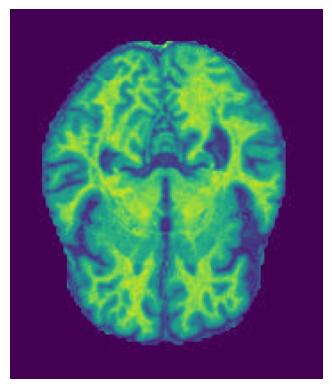

In [14]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

jpg_files = [f for f in os.listdir(veryMildDemented
                                   ) if f.endswith('.jpg')]
random_jpg_file = random.choice(jpg_files)

img_path = os.path.join(veryMildDemented, random_jpg_file)
img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# 1. Define a composition of transformations - only resize here, as the processor handles ToTensor and Normalize
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224 pixels
])

# 2. Load the dataset using ImageFolder and apply data_transforms
full_dataset = ImageFolder(root=image_path, transform=data_transforms)

total_size = len(full_dataset)
test_size = int(0.2 * total_size)
dev_size = total_size - test_size

dev_dataset, test_dataset = random_split(full_dataset,
                                  [dev_size, test_size],
                                  generator=torch.Generator().manual_seed(42))

print(f"Number of images in the dataset: {len(full_dataset)}")
print(f"Dev set: {len(dev_dataset)} Test set: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")

Number of images in the dataset: 6400
Dev set: 5120 Test set: 1280
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


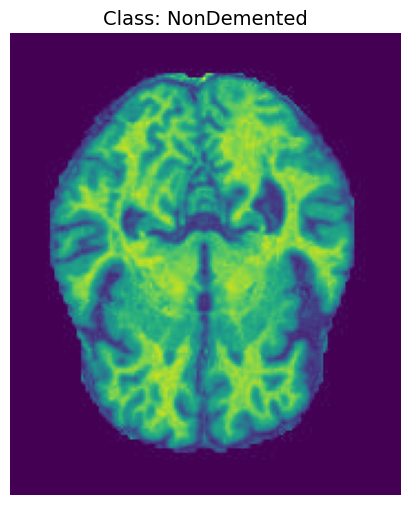

Displaying image 3227 - Class: NonDemented


In [16]:
import matplotlib.pyplot as plt
import random

random_index = random.randint(0, len(full_dataset) - 1)
random_image, label = full_dataset[random_index]

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f'Class: {full_dataset.classes[label]}', fontsize=14)
plt.axis('off')
plt.show()

print(f"Displaying image {random_index} - Class: {full_dataset.classes[label]}")

In [17]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

num_splits = 5  # Define the number of folds for cross-validation
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)

BATCH_SIZE = 32 # Define batch size for DataLoaders

# Lists to store training and validation DataLoaders for each fold
train_loaders = []
val_loaders = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dev_dataset)):
    print(f"\n--- Creating DataLoader for Fold {fold+1}/{num_splits} ---")

    # Create Subset for training and validation data
    train_subset = Subset(dev_dataset, train_idx)
    val_subset = Subset(dev_dataset, val_idx)

    # Create DataLoaders for current fold
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Store DataLoaders
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold+1}: Training DataLoader has {len(train_loader)} batches (total {len(train_subset)} samples).")
    print(f"Fold {fold+1}: Validation DataLoader has {len(val_loader)} batches (total {len(val_subset)} samples).")

print("\nAll training and validation DataLoaders created for all folds.")


--- Creating DataLoader for Fold 1/5 ---
Fold 1: Training DataLoader has 128 batches (total 4096 samples).
Fold 1: Validation DataLoader has 32 batches (total 1024 samples).

--- Creating DataLoader for Fold 2/5 ---
Fold 2: Training DataLoader has 128 batches (total 4096 samples).
Fold 2: Validation DataLoader has 32 batches (total 1024 samples).

--- Creating DataLoader for Fold 3/5 ---
Fold 3: Training DataLoader has 128 batches (total 4096 samples).
Fold 3: Validation DataLoader has 32 batches (total 1024 samples).

--- Creating DataLoader for Fold 4/5 ---
Fold 4: Training DataLoader has 128 batches (total 4096 samples).
Fold 4: Validation DataLoader has 32 batches (total 1024 samples).

--- Creating DataLoader for Fold 5/5 ---
Fold 5: Training DataLoader has 128 batches (total 4096 samples).
Fold 5: Validation DataLoader has 32 batches (total 1024 samples).

All training and validation DataLoaders created for all folds.


In [22]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import numpy as np


# 1. Load the pretrained model and processor
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

num_labels = len(full_dataset.classes)



# 4. Custom dataset that works with JPG/PIL Images
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get PIL Image (converted from JPG) and label
        image, label = self.dataset[idx]

        # Processor handles PIL Images perfectly
        inputs = self.processor(images=image, return_tensors="pt")

        # Remove batch dimension and add label
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = label
        return inputs




In [23]:
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

fold_results = []
for i in range(len(train_loaders)):
  print(f"Fold {i+1}")

  train_dataset = ImageDataset(train_loaders[i].dataset, processor)
  val_dataset = ImageDataset(val_loaders[i].dataset, processor)

  model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True  # For changing the classification head
  )

  training_args = TrainingArguments(
    output_dir="./vit-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.00005,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    remove_unused_columns=False,
    report_to="tensorboard",
  )

  accuracy_metric = evaluate.load("accuracy")



  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )

  trainer.train()

  results = trainer.evaluate()

  fold_results.append(results)
  print(f"Validation accuracy: {results['eval_accuracy']:.4f}")
  print(f"Validation loss: {results['eval_loss']:.4f}")
  print(f"Validation f1: {results['eval_f1']:.4f}")
  print(f"Validation precision: {results['eval_precision']:.4f}")
  print(f"Validation recall: {results['eval_recall']:.4f}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.677670,0.717773,0.703916,0.717773,0.696521
2,0.614400,0.234589,0.919922,0.927184,0.919922,0.919899
3,0.614400,0.149281,0.956055,0.959136,0.956055,0.956500
4,0.051200,0.136863,0.969727,0.969873,0.969727,0.969768
5,0.051200,0.136079,0.968750,0.969045,0.968750,0.968815


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.9697
Validation loss: 0.1369
Validation f1: 0.9698
Validation precision: 0.9699
Validation recall: 0.9697
Fold 2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.597447,0.763672,0.757766,0.763672,0.750743
2,0.587100,0.367412,0.869141,0.896422,0.869141,0.867832
3,0.587100,0.222198,0.943359,0.945783,0.943359,0.942889
4,0.046200,0.167656,0.959961,0.961482,0.959961,0.960060
5,0.046200,0.144483,0.966797,0.967180,0.966797,0.966829


Validation accuracy: 0.9668
Validation loss: 0.1445
Validation f1: 0.9668
Validation precision: 0.9672
Validation recall: 0.9668
Fold 3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.508810,0.806641,0.798833,0.806641,0.797713
2,0.567800,0.376676,0.860352,0.871759,0.860352,0.852544
3,0.567800,0.215466,0.942383,0.942620,0.942383,0.941356
4,0.039900,0.147904,0.965820,0.965931,0.965820,0.965562
5,0.039900,0.155623,0.963867,0.964024,0.963867,0.963637


Validation accuracy: 0.9658
Validation loss: 0.1479
Validation f1: 0.9656
Validation precision: 0.9659
Validation recall: 0.9658
Fold 4


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.538860,0.777344,0.768086,0.777344,0.772150
2,0.585900,0.225203,0.916016,0.924011,0.916016,0.914173
3,0.585900,0.477762,0.868164,0.889458,0.868164,0.869240
4,0.046700,0.171074,0.958008,0.958756,0.958008,0.957944
5,0.046700,0.174531,0.961914,0.962293,0.961914,0.961740


Validation accuracy: 0.9619
Validation loss: 0.1745
Validation f1: 0.9617
Validation precision: 0.9623
Validation recall: 0.9619
Fold 5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.538694,0.791992,0.798747,0.791992,0.783209
2,0.538100,0.530892,0.817383,0.868901,0.817383,0.811718
3,0.538100,0.203675,0.946289,0.947288,0.946289,0.946023
4,0.040500,0.169388,0.960938,0.961320,0.960938,0.960846
5,0.040500,0.155161,0.963867,0.963932,0.963867,0.963852


Validation accuracy: 0.9639
Validation loss: 0.1552
Validation f1: 0.9639
Validation precision: 0.9639
Validation recall: 0.9639


In [24]:
best_fold = np.argmax([r['eval_accuracy'] for r in fold_results])

# Train final model on ALL dev data (all k-fold data combined)
final_train_dataset = ImageDataset(dev_dataset, processor)

# Reinitialize model
final_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

final_training_args = TrainingArguments(
    output_dir="./vit-final-model",
    eval_strategy="no",  # No validation during final training
    save_strategy="epoch",
    learning_rate=0.00005,
    per_device_train_batch_size=16,
    num_train_epochs=5,  # Use same hyperparameters from best fold
    weight_decay=0.01,
    fp16=True,
    remove_unused_columns=False,
    report_to="none",
)

final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=final_train_dataset,
    compute_metrics=compute_metrics,
)

final_trainer.train()

# ==================== TEST ON HELD-OUT TEST SET ====================
print(f"\n{'='*50}")
print("FINAL EVALUATION ON TEST SET")
print(f"{'='*50}")

test_dataset_wrapped = ImageDataset(test_dataset, processor)

test_results = final_trainer.evaluate(test_dataset_wrapped)

print(f"\n🎯 FINAL TEST RESULTS:")
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Test Loss: {test_results['eval_loss']:.4f}")
print(f"Test F1: {test_results['eval_f1']:.4f}")
print(f"Test Precision: {test_results['eval_precision']:.4f}")
print(f"Test Recall: {test_results['eval_recall']:.4f}")

# Save the final model
final_trainer.save_model("./vit-final-model-best")
processor.save_pretrained("./vit-final-model-best")
print("\n✅ Final model saved to './vit-final-model-best'")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.556600
1000,0.069700
1500,0.000800


Step,Training Loss
500,0.556600
1000,0.069700
1500,0.000800



FINAL EVALUATION ON TEST SET



🎯 FINAL TEST RESULTS:
Test Accuracy: 0.9922
Test Loss: 0.0481
Test F1: 0.9922
Test Precision: 0.9922
Test Recall: 0.9922

✅ Final model saved to './vit-final-model-best'


In [25]:
test_results

{'eval_loss': 0.048133306205272675,
 'eval_accuracy': 0.9921875,
 'eval_precision': 0.9921909561214155,
 'eval_recall': 0.9921875,
 'eval_f1': 0.9921836431699548,
 'eval_runtime': 9.8438,
 'eval_samples_per_second': 130.032,
 'eval_steps_per_second': 16.254,
 'epoch': 5.0}

For Augmented Dataset Transformer:

- Test Accuracy: 0.9826

- Test Loss: 0.0789

- Test F1: 0.9826

- Test Precision: 0.9826

- Test Recall: 0.9826


For Original Dataset Transformer
- Test Accuracy: 0.9789

- Test Loss: 0.0811

- Test F1: 0.9788

- Test Precision: 0.9789

- Test Recall: 0.9789

In [26]:
# efficient net
import torch
from transformers import EfficientNetForImageClassification, EfficientNetImageProcessor, TrainingArguments, Trainer

# 1. EfficientNet Setup
efficientnet_model_name = "google/efficientnet-b0"
efficientnet_processor = EfficientNetImageProcessor.from_pretrained(efficientnet_model_name)
efficientnet_fold_results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





preprocessor_config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [27]:
# EFFICIENTNET
import torch
import numpy as np
from transformers import EfficientNetForImageClassification, EfficientNetImageProcessor, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- Define Compute Metrics Locally ---
# This function is now defined within this block, replacing the need for an external call.
def efficientnet_compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# --- K-Fold Cross-Validation ---
efficientnet_fold_results = []
# Uses the train_loaders and val_loaders generated in Cell 22
for i in range(len(train_loaders)):
    print(f"\n--- EfficientNet Fold {i+1} ---")

    # Use EfficientNet-specific processor with the reusable ImageDataset class
    train_dataset = ImageDataset(train_loaders[i].dataset, efficientnet_processor)
    val_dataset = ImageDataset(val_loaders[i].dataset, efficientnet_processor)

    # Load EfficientNet model
    efficientnet_model = EfficientNetForImageClassification.from_pretrained(
        efficientnet_model_name,
        num_labels=num_labels, # Uses previous num_labels defined earlier
        ignore_mismatched_sizes=True
    ).to(device)

    # hyperparamters consistent
    efficientnet_training_args = TrainingArguments(
        output_dir=f"./efficientnet-finetuned/fold-{i+1}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=0.001,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=True,
        remove_unused_columns=False,
        report_to="tensorboard",
        run_name=f"efficientnet-fold-{i+1}",
    )

    efficientnet_trainer = Trainer(
        model=efficientnet_model,
        args=efficientnet_training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=efficientnet_compute_metrics, # NOW USES LOCAL FUNCTION
    )

    efficientnet_trainer.train()
    results = efficientnet_trainer.evaluate()
    efficientnet_fold_results.append(results)
    print(f"EfficientNet Fold {i+1} Validation Accuracy: {results['eval_accuracy']:.4f}")

# final training on dev set
print(f"\n{'='*50}")
print("EfficientNet FINAL TRAINING ON DEV SET")
print(f"{'='*50}")



# Save the final model
# final_efficientnet_trainer.save_model("./efficientnet-final-model-best")
# efficientnet_processor.save_pretrained("./efficientnet-final-model-best")
# print("✅ EfficientNet Final model saved to './efficientnet-final-model-best'")


--- EfficientNet Fold 1 ---


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.639379,0.747070,0.776250,0.747070,0.738343
2,0.612000,0.589545,0.787109,0.829767,0.787109,0.792531
3,0.612000,0.327941,0.875000,0.889354,0.875000,0.876735
4,0.171900,0.219483,0.933594,0.938066,0.933594,0.934428
5,0.171900,0.155644,0.958008,0.958255,0.958008,0.957923
6,0.051300,0.145935,0.958984,0.959652,0.958984,0.958846
7,0.051300,0.064727,0.980469,0.980551,0.980469,0.980422
8,0.011200,0.062272,0.975586,0.976025,0.975586,0.975648
9,0.011200,0.062577,0.985352,0.985353,0.985352,0.985323
10,0.002100,0.071355,0.985352,0.985650,0.985352,0.985345


EfficientNet Fold 1 Validation Accuracy: 0.9854

--- EfficientNet Fold 2 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.522647,0.784180,0.810627,0.784180,0.775977
2,0.600700,0.230586,0.926758,0.927917,0.926758,0.926742
3,0.600700,0.247616,0.921875,0.922359,0.921875,0.921706
4,0.150600,0.326234,0.901367,0.916526,0.901367,0.901598
5,0.150600,0.151031,0.958984,0.959172,0.958984,0.959030
6,0.048100,0.147235,0.961914,0.963591,0.961914,0.961722
7,0.048100,0.089808,0.971680,0.971671,0.971680,0.971615
8,0.011000,0.097537,0.973633,0.974034,0.973633,0.973666
9,0.011000,0.100461,0.970703,0.971614,0.970703,0.970787
10,0.003500,0.067792,0.979492,0.979759,0.979492,0.979543


EfficientNet Fold 2 Validation Accuracy: 0.9795

--- EfficientNet Fold 3 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.523153,0.793945,0.809817,0.793945,0.788501
2,0.592500,0.393202,0.854492,0.870532,0.854492,0.848192
3,0.592500,0.227215,0.929688,0.930716,0.929688,0.929199
4,0.149000,0.268535,0.936523,0.938913,0.936523,0.935013
5,0.149000,0.154354,0.955078,0.956894,0.955078,0.955298
6,0.049600,0.174492,0.958984,0.961372,0.958984,0.959329
7,0.049600,0.067348,0.979492,0.979524,0.979492,0.979457
8,0.011100,0.083836,0.980469,0.980640,0.980469,0.980379
9,0.011100,0.069809,0.981445,0.981689,0.981445,0.981437


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.523153,0.793945,0.809817,0.793945,0.788501
2,0.592500,0.393202,0.854492,0.870532,0.854492,0.848192
3,0.592500,0.227215,0.929688,0.930716,0.929688,0.929199
4,0.149000,0.268535,0.936523,0.938913,0.936523,0.935013
5,0.149000,0.154354,0.955078,0.956894,0.955078,0.955298
6,0.049600,0.174492,0.958984,0.961372,0.958984,0.959329
7,0.049600,0.067348,0.979492,0.979524,0.979492,0.979457
8,0.011100,0.083836,0.980469,0.980640,0.980469,0.980379
9,0.011100,0.069809,0.981445,0.981689,0.981445,0.981437
10,0.002600,0.064713,0.984375,0.984400,0.984375,0.984312


EfficientNet Fold 3 Validation Accuracy: 0.9844

--- EfficientNet Fold 4 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.677165,0.738281,0.782383,0.738281,0.743914
2,0.547200,0.417458,0.845703,0.862459,0.845703,0.840198
3,0.547200,0.214196,0.926758,0.930083,0.926758,0.927490
4,0.156600,0.227625,0.923828,0.934337,0.923828,0.925948
5,0.156600,0.119939,0.965820,0.965988,0.965820,0.965816
6,0.056400,0.119881,0.970703,0.972243,0.970703,0.970843
7,0.056400,0.070173,0.982422,0.982681,0.982422,0.982451
8,0.010000,0.063972,0.980469,0.980554,0.980469,0.980484
9,0.010000,0.049987,0.985352,0.985350,0.985352,0.985350
10,0.002100,0.055913,0.986328,0.986307,0.986328,0.986309


EfficientNet Fold 4 Validation Accuracy: 0.9863

--- EfficientNet Fold 5 ---


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.524111,0.773438,0.775555,0.773438,0.772436
2,0.595800,0.407479,0.847656,0.855222,0.847656,0.844436
3,0.595800,0.272361,0.916992,0.920618,0.916992,0.916451
4,0.151700,0.183464,0.945312,0.948499,0.945312,0.945631
5,0.151700,0.228635,0.935547,0.940419,0.935547,0.936172
6,0.042600,0.099977,0.976562,0.977158,0.976562,0.976696
7,0.042600,0.067587,0.975586,0.975928,0.975586,0.975515
8,0.014900,0.110524,0.963867,0.965378,0.963867,0.963974
9,0.014900,0.060810,0.982422,0.982679,0.982422,0.982448
10,0.003100,0.086510,0.975586,0.976126,0.975586,0.975480


EfficientNet Fold 5 Validation Accuracy: 0.9824

EfficientNet FINAL TRAINING ON DEV SET


In [28]:
final_train_dataset = ImageDataset(dev_dataset, efficientnet_processor)
final_efficientnet_model = EfficientNetForImageClassification.from_pretrained(
    efficientnet_model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
).to(device)

final_efficientnet_training_args = TrainingArguments(
    output_dir="./efficientnet-final-model",
    eval_strategy="no",
    save_strategy="epoch",
    learning_rate=0.001,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    remove_unused_columns=False,
    report_to="none",
)

final_efficientnet_trainer = Trainer(
    model=final_efficientnet_model,
    args=final_efficientnet_training_args,
    train_dataset=final_train_dataset,
    compute_metrics=efficientnet_compute_metrics, # NOW USES LOCAL FUNCTION
)
final_efficientnet_trainer.train()

# --- FINAL EVALUATION ON HELD-OUT TEST SET ---
print(f"\n{'='*50}")
print("EfficientNet FINAL EVALUATION ON TEST SET")
print(f"{'='*50}")
test_dataset_wrapped = ImageDataset(test_dataset, efficientnet_processor)
efficientnet_test_results = final_efficientnet_trainer.evaluate(test_dataset_wrapped)

print(f"\n🎯 EfficientNet FINAL TEST RESULTS:")
print(f"Test Accuracy: {efficientnet_test_results['eval_accuracy']:.4f}")
print(f"Test Loss: {efficientnet_test_results['eval_loss']:.4f}")
print(f"Test F1: {efficientnet_test_results['eval_f1']:.4f}")
print(f"Test Precision: {efficientnet_test_results['eval_precision']:.4f}")
print(f"Test Recall: {efficientnet_test_results['eval_recall']:.4f}")


# Save the final model
final_trainer.save_model("./effNet-final-model-best")
processor.save_pretrained("./effNet-final-model-best")
print("\n✅ Final model saved to './effNet-final-model-best'")

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.595500
1000,0.143700
1500,0.026200



EfficientNet FINAL EVALUATION ON TEST SET



🎯 EfficientNet FINAL TEST RESULTS:
Test Accuracy: 0.9836
Test Loss: 0.0483
Test F1: 0.9836
Test Precision: 0.9838
Test Recall: 0.9836

✅ Final model saved to './effNet-final-model-best'


In [29]:
Test Accuracy: 0.9867
Test Loss: 0.0423
Test F1: 0.9867
Test Precision: 0.9867
Test Recall: 0.9867

SyntaxError: invalid syntax (ipython-input-4243356255.py, line 1)